In [1]:
from __future__ import print_function
from __future__ import division

import make_dictionaries
import os
import math
import params

import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import pickle
from scipy.optimize import minimize
import time
from voronoi_2d_binning import voronoi_2d_binning
from sklearn.neighbors import NearestNeighbors

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [3]:
def voronoi_binning(R50, Mr, n_rect_bins=500, n_per_voronoi_bin=5000,save=False):
    
    rect_bin_val, R50_bin_edges, Mr_bin_edges = np.histogram2d(R50, Mr, n_rect_bins)

    rect_bins_table = Table(data=[R50_bin_edges, Mr_bin_edges],
                            names=['R50_bin_edges', 'Mr_bin_edges'])
    rect_bins_table.meta['nrectbin'] = n_rect_bins # add value for number of 
    # bins to the table. 
    
    # Get bin centres + number of bins:
    R50_bin_centres = 0.5*(R50_bin_edges[:-1] + R50_bin_edges[1:])
    Mr_bin_centres = 0.5*(Mr_bin_edges[:-1] + Mr_bin_edges[1:]) 
    n_R50_bins = len(R50_bin_centres)
    n_Mr_bins = len(Mr_bin_centres)

    # Get ranges:
    R50_bins_min, Mr_bins_min = map(np.min, (R50_bin_centres, Mr_bin_centres))
    R50_bins_max, Mr_bins_max = map(np.max, (R50_bin_centres, Mr_bin_centres))
    R50_bins_range = R50_bins_max - R50_bins_min
    Mr_bins_range = Mr_bins_max - Mr_bins_min
    
    # 'Ravel' out the coordinate bins (.'. length=n_bin*n_bin)
    R50_bin_coords = R50_bin_centres.repeat(n_rect_bins).reshape(n_rect_bins, n_rect_bins).ravel()
    Mr_bin_coords = Mr_bin_centres.repeat(n_rect_bins).reshape(n_rect_bins, n_rect_bins).T.ravel()

    # Only keep bins that contain a galaxy:
    signal = rect_bin_val.ravel() # signal=number of gals.
    ok_bin = (signal > 0).nonzero()[0]
    signal = signal[ok_bin]

    # Normalise x + y to be between 0 and 1:
    x = (R50_bin_coords[ok_bin] - R50_bins_min) / R50_bins_range
    y = (Mr_bin_coords[ok_bin] - Mr_bins_min) / Mr_bins_range

    # Voronoi_2d_binning aims for a target S/N
    noise = np.sqrt(signal)
    targetSN = np.sqrt(n_per_voronoi_bin)

    output = voronoi_2d_binning(x, y, signal, noise, targetSN, plot=0, quiet=1, wvt=True)
    binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = output

    vbin = np.unique(binNum)
    count = (sn**2).astype(np.int) # N_gals for each voronoi bin.
    R50_vbin_mean = xBar * R50_bins_range + R50_bins_min
    Mr_vbin_mean = yBar * Mr_bins_range + Mr_bins_min
    
    vbins_table = Table(data=[vbin, R50_vbin_mean, Mr_vbin_mean,
                              count, nPixels],
                        names=['vbin', 'R50', 'Mr', 
                               'count_gals', 'count_rect_bins'])
    vbins_table.meta['nrectbin'] = n_rect_bins
    vbins_table.meta['nperbin'] = n_per_voronoi_bin

    # Populate elements of the rectangular grid with
    # the voronoi bin indices and counts
    rect_bin_voronoi_bin = np.zeros(np.product(rect_bin_val.shape), np.int) - 1
    rect_bin_voronoi_bin[ok_bin] = binNum
    rect_bin_count = np.zeros_like(rect_bin_voronoi_bin)
    rect_bin_count[ok_bin] = count
    
    rect_vbins_table = Table(data=[R50_bin_coords, Mr_bin_coords,
                             rect_bin_voronoi_bin],
                             names=['R50', 'Mr', 'vbin'])
    rect_bins_table.meta['nrectbin'] = n_rect_bins
    rect_bins_table.meta['nperbin'] = n_per_voronoi_bin
    
    if save == True:
        rect_bins_table.write(save_directory + 'rect_bins_table.fits', overwrite=True)
        vbins_table.write(save_directory + 'vbins_table.fits', overwrite=True)
        rect_vbins_table.write(save_directory + 'rect_vbins_table.fits', overwrite=True)
        
    plt.hist(vbins_table['count_gals'],histtype='stepfilled',color='b',alpha=0.5,linewidth=0)
    ylims = plt.gca().get_ylim()
    plt.vlines(n_per_voronoi_bin,ylims[0],ylims[1],color='k',linewidth=3,linestyle='dotted')
    plt.ylabel('$N_{bin}$')
    plt.xlabel('$N_{gal}$')
    
    # rect_bins_table: contains all of the bin edges (len=N_bins)
    # rect_vbins_table: has bin centre values + assigned v-bin (len=N_bins**2)
    # vbins_table: for each bin, contains the number of gals, Mr+R50 mean
    # values + the number of rectangular bins it is made up of (len=N_v-bins)
    return rect_bins_table, vbins_table, rect_vbins_table, Mr_bins_min, Mr_bins_range, R50_bins_min, R50_bins_range

In [4]:
def redshift_binning(data,voronoi_bins,min_gals=100):
    
    redshift = data['REDSHIFT_1']
    z_bins = []

    for N in np.unique(voronoi_bins):
        inbin = voronoi_bins == N
        n_with_morph = np.sum(inbin)
        #n_zbins = n_with_morph/min_gals
        n_zbins = 5
        z = redshift[inbin]
        z = np.sort(z)
        bin_edges = np.linspace(0, len(z)-1, n_zbins+1, dtype=np.int)
        z_edges = z[bin_edges]
        z_edges[0] = 0
        z_edges[-1] = 1
        
        z_bins.append(z_edges)
        
    return z_bins

In [5]:
def voronoi_assignment(data, rect_bins_table, rect_vbins_table,
                       Mr_bins_min, Mr_bins_range, R50_bins_min, R50_bins_range,
                       reassign=False):
    R50_bin_edges = rect_bins_table['R50_bin_edges']
    Mr_bin_edges = rect_bins_table['Mr_bin_edges']
    n_R50_bins = len(R50_bin_edges) - 1
    n_Mr_bins = len(Mr_bin_edges) - 1
    
    R50 = np.log10(data['PETROR50_R_KPC'])
    Mr = data['PETROMAG_MR']
    
    # get the R50 and Mr bin for each galaxy in the sample
    R50_bins = np.digitize(R50, bins=R50_bin_edges).clip(1, n_R50_bins)
    Mr_bins = np.digitize(Mr, bins=Mr_bin_edges).clip(1, n_Mr_bins)

    # convert R50 and Mr bin indices to indices of bins
    # in the combined rectangular grid
    rect_bins = (Mr_bins - 1) + n_Mr_bins * (R50_bins - 1)

    # get the voronoi bin for each galaxy in the sample
    rect_bin_vbins = rect_vbins_table['vbin']
    voronoi_bins = rect_bin_vbins[rect_bins]
    
    if reassign is True: # Find nearest bin if none available
        rect_bins_assigned = rect_vbins_table[rect_vbins_table['vbin'] != -1]
        R50_bin = rect_bins_assigned['R50']
        Mr_bin = rect_bins_assigned['Mr']
        
        x = (R50_bin - R50_bins_min) / R50_bins_range
        y = (Mr_bin - Mr_bins_min) / Mr_bins_range
        
        unassigned = voronoi_bins == -1
        R50u = (R50[unassigned] - R50_bins_min) / R50_bins_range
        Mru = (Mr[unassigned] - Mr_bins_min) / Mr_bins_range
        
        xy = (np.array([R50u,Mru])).T
        xy_ref = (np.array([x,y])).T
        
        nbrs = NearestNeighbors(n_neighbors=1,algorithm='ball_tree').fit(xy_ref,xy)
        d,i = nbrs.kneighbors(xy)
        i = i.squeeze()
        vbins_reassigned = rect_bins_assigned['vbin'][i]
        voronoi_bins[voronoi_bins == -1] = vbins_reassigned
    
    return voronoi_bins

In [6]:
def redshift_assignment(data,vbins,zbin_ranges):
    
    zbins = np.zeros(len(data))
    
    for v in (np.unique(vbins)):
        z_range = zbin_ranges[v]
        v_data = data[vbins == v]['REDSHIFT_1']
        z_bin = np.digitize(v_data,bins=z_range)
        zbins[vbins == v] = z_bin
        
    return zbins

In [7]:
def bin_data(data,n_vbins=40,signal=100,plot=True):
    
    R50 = data['PETROR50_R_KPC'][fv_nonzero]
    rect_bins_table,vbins_table,rect_vbins_table,Mr_bins_min,Mr_bins_range,R50_bins_min,R50_bins_range = voronoi_binning(np.log10(R50),
                                                                                                                         data['PETROMAG_MR'][fv_nonzero],
                                                                                                                         n_per_voronoi_bin=np.sum(fv_nonzero)/n_vbins)

    vbins = voronoi_assignment(data[fv_nonzero],rect_bins_table,rect_vbins_table,Mr_bins_min,
                               Mr_bins_range, R50_bins_min, R50_bins_range)
    zbin_ranges = redshift_binning(data[fv_nonzero],vbins,min_gals=signal)
    
    vbins = voronoi_assignment(data, rect_bins_table, rect_vbins_table,
                           Mr_bins_min, Mr_bins_range, R50_bins_min, R50_bins_range,
                           reassign=True)
    
    zbins = redshift_assignment(data,vbins,zbin_ranges)
    
    N_v = np.unique(vbins)
    N_z = []
    
    for v in N_v:
        zbins_v = zbins[vbins == v]
        N_z.append(np.max(zbins_v))
        
    print('{} voronoi bins'.format(len(N_v)))
    print('{} redshift bins per voronoi bin'.format(np.mean(N_z)))
    
    if plot == True:
        
        relative_r = [((T-T.min())/(T.max()-T.min())) for T in [vbins_table['R50'],vbins_table['Mr']]]
        relative_r = relative_r[1]# + relative_r[1]
        r_sort = np.argsort(relative_r)

        for N in np.unique(vbins)[r_sort]:
            inbin = vbins == N
            plt.plot(data['PETROR50_R_KPC'][inbin],data['PETROMAG_MR'][inbin], '.')
    
        for N in range(len(vbins_table)):
            x_text_pos = 10**(vbins_table['R50'][N])
            y_text_pos = vbins_table['Mr'][N]
            plt.text(x_text_pos,y_text_pos,'{}'.format(N),
                     color='w',horizontalalignment='center',
                     verticalalignment='center')

        plt.ylabel(r"$M_r$")
        plt.xlabel(r"$R_{50}$ (kpc)")
        plt.xscale('log')
        _ = plt.axis((0.5, 60, -18, -25))
        
        plt.savefig('figures/voronoi_binning/{}_{}.png'.format(question,answer))
        
    return vbins,zbins,vbins_table

In [8]:
source_directory = params.source_directory
save_directory = params.numpy_save_directory
full_sample = params.full_sample
volume_limited_sample = params.volume_limited_sample
question = params.question
bins_to_plot = params.bins_to_plot
print('Question to be debiased: {}'.format(question))

min_log_fv = -1.5#np.log10(0.1)
max_log_fv = 0.01

Question to be debiased: t01_smooth_or_features


In [9]:
data = Table.read(source_directory + full_sample)
print('Loaded galaxy data...')
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

low_z_lim = 0.03
data = data[data['REDSHIFT_1'] > low_z_lim]

# For this code, go through each of the answers separately
answers = questions[question]['answers']
answer = answers[0] # Only do 1 answer this time.
raw_column = data[question + '_' + answer + '_weighted_fraction']
fv_nonzero = raw_column > 0 # Select only the non-zero data to add to the 'signal' for each bin.

Loaded galaxy data...
Loaded questions...
Loaded functions...


Bin-accretion...
1629  initial bins.
Reassign bad bins...
25  good bins.
Modified Lloyd algorithm...
23  iterations.
Unbinned pixels:  0  /  39004
Fractional S/N scatter (%): 8.51802453966
25 voronoi bins
5.0 redshift bins per voronoi bin


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:59: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


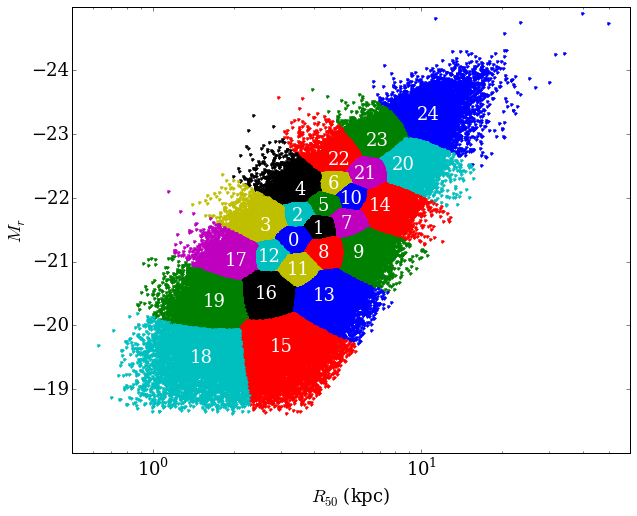

In [114]:
vbins,zbins,vbins_table = bin_data(data,plot=True)

In [209]:
def f_logistic(x,k,c,l):
    alpha = np.exp(-k*x + c)
    return l/(1+alpha)
    #return 1/(1+alpha)

def f_exp_pow(x,k,c,x0):
    return np.exp((-k)*(-x+x0)**c)
    

In [210]:
def get_fit_setup(fit_setup):

    func = fit_setup['f']
    p0 = fit_setup['p0']
    bounds = fit_setup['bounds']
    
    return func, p0, bounds

In [214]:
def chisq_fun(p, f, x, y):
    return ((f(x, *p) - y)**2).sum()


def fit_vbin_function(data, vbins, zbins, fit_setup,
                      question,questions,kc_fit_results=None,
                      plot=bins_to_plot,min_log_fv=min_log_fv,
                      even_sampling=True):
    
    start_time = time.time()

    redshift = data['REDSHIFT_1']
    fv = question + '_' + answer +'_weighted_fraction'
    
    if kc_fit_results is not None:
        kcfunc, kparams, cparams, lparams,kclabel = kc_fit_results
    
    # Set up the list to write the parameters in to:
    param_data = []
    
    max_z_bins_to_plot = 5
    
    # Loop over Voronoi magnitude-size bins
    for v in np.unique(vbins):
        vselect = vbins == v
        data_v = data[vselect]
        zbins_v = zbins[vselect]

        z_bins_unique = np.unique(zbins_v)

        for z in z_bins_unique:
            data_z = data_v[zbins_v == z]
            n = len(data_z)
            
            D = data_z[[fv]]
            D.sort(fv)
            D['cumfrac'] = np.linspace(0, 1, n)
                #D = D[D[fv] > min_fv]
            D['log10fv'] = np.log10(D[fv])
            if even_sampling:
                D_fit_log10fv = np.log10(np.linspace(10**(min_log_fv), 1, 100))
                D = D[(D['log10fv'] > min_log_fv) & (D['log10fv'] < max_log_fv)]
                indices = np.searchsorted(D['log10fv'], D_fit_log10fv)
                D_fit = D[indices.clip(0, len(D)-1)]
            else:
                D = D[D['log10fv'] > min_log_fv]

                # Fit function to the cumulative fraction
                # Start fits off in roughly right place with sensible bounds
            func, p0, bounds = get_fit_setup(fit_setup)
                # Note that need to cast x and y to float64 in order
                # for minimisation to work correctly
            res = minimize(chisq_fun, p0,
                           args=(func,
                                 D['log10fv'].astype(np.float64),
                                 D['cumfrac'].astype(np.float64)),
                           bounds=bounds, method='Nelder-Mead')
            p = res.x
            chi2nu = res.fun / (n - len(p))
                
            means = [data_z['PETROMAG_MR'].mean(),
                     np.log10(data_z['PETROR50_R_KPC']).mean(),
                     data_z['REDSHIFT_1'].mean()]

            if len(p) < 2:
                p = np.array([p[0], 10])

            param_data.append([v,z] + means + p[:3].tolist() + # Maybe change output table here
                              [chi2nu])
            
    fit_vbin_results = Table(rows=param_data,
                             names=('vbin','zbin', 'Mr',
                                    'R50', 'redshift', 'k', 'c','l', 'chi2nu'))
    
    print('All bins fitted! {}s in total'.format(time.time()-start_time))
    
    return fit_vbin_results

In [215]:
# Fit each of the bins in turn:
fit_setup = {}
fit_setup['f'] = f_exp_pow
fit_setup['p0'] = [1,1,0]
fit_setup['bounds'] = ((10**(-5),10**5),(0.5,2),(-1,1))

fit_vbin_results = fit_vbin_function(data,vbins,zbins,fit_setup,question,questions)

All bins fitted! 73.52926516532898s in total


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/scipy/optimize/_minimize.py:369: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


In [222]:
def plot_row(axes,row,datacol,colorby,xlabel,vbins=vb):
    
    axes[row,0].scatter(datacol,np.log10(k),
                        c=colorby,
                        cmap=plt.cm.coolwarm,marker='o',lw=0,s=30)
              
    axes[row,1].scatter(datacol,np.log10(c),
                        c=colorby,
                        cmap=plt.cm.coolwarm,marker='o',lw=0,s=30)
    
    if vbins != None:
        for v in np.unique(vb):
            axes[row,0].plot(datacol[vbins == v],np.log10(k)[vbins == v],color='k',alpha=0.5)
            axes[row,1].plot(datacol[vbins == v],np.log10(-c)[vbins == v],color='k',alpha=0.5)
    
    axes[row,2].scatter(datacol,y0,
                        c=colorby,
                        cmap=plt.cm.coolwarm,marker='o',lw=0,s=30)
    
    axes[row,3].scatter(datacol,chisq,
                        c=colorby,
                        cmap=plt.cm.coolwarm,marker='o',lw=0,s=30)
    
    ylabels = ['logk','log(-c)','log(y(0))',r'$\chi^2$']
    
    for col,ax in enumerate(axes[row,:]):
        ax.set_ylabel(ylabels[col])
        ax.set_xlabel(xlabel)
    
    return None

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in log10


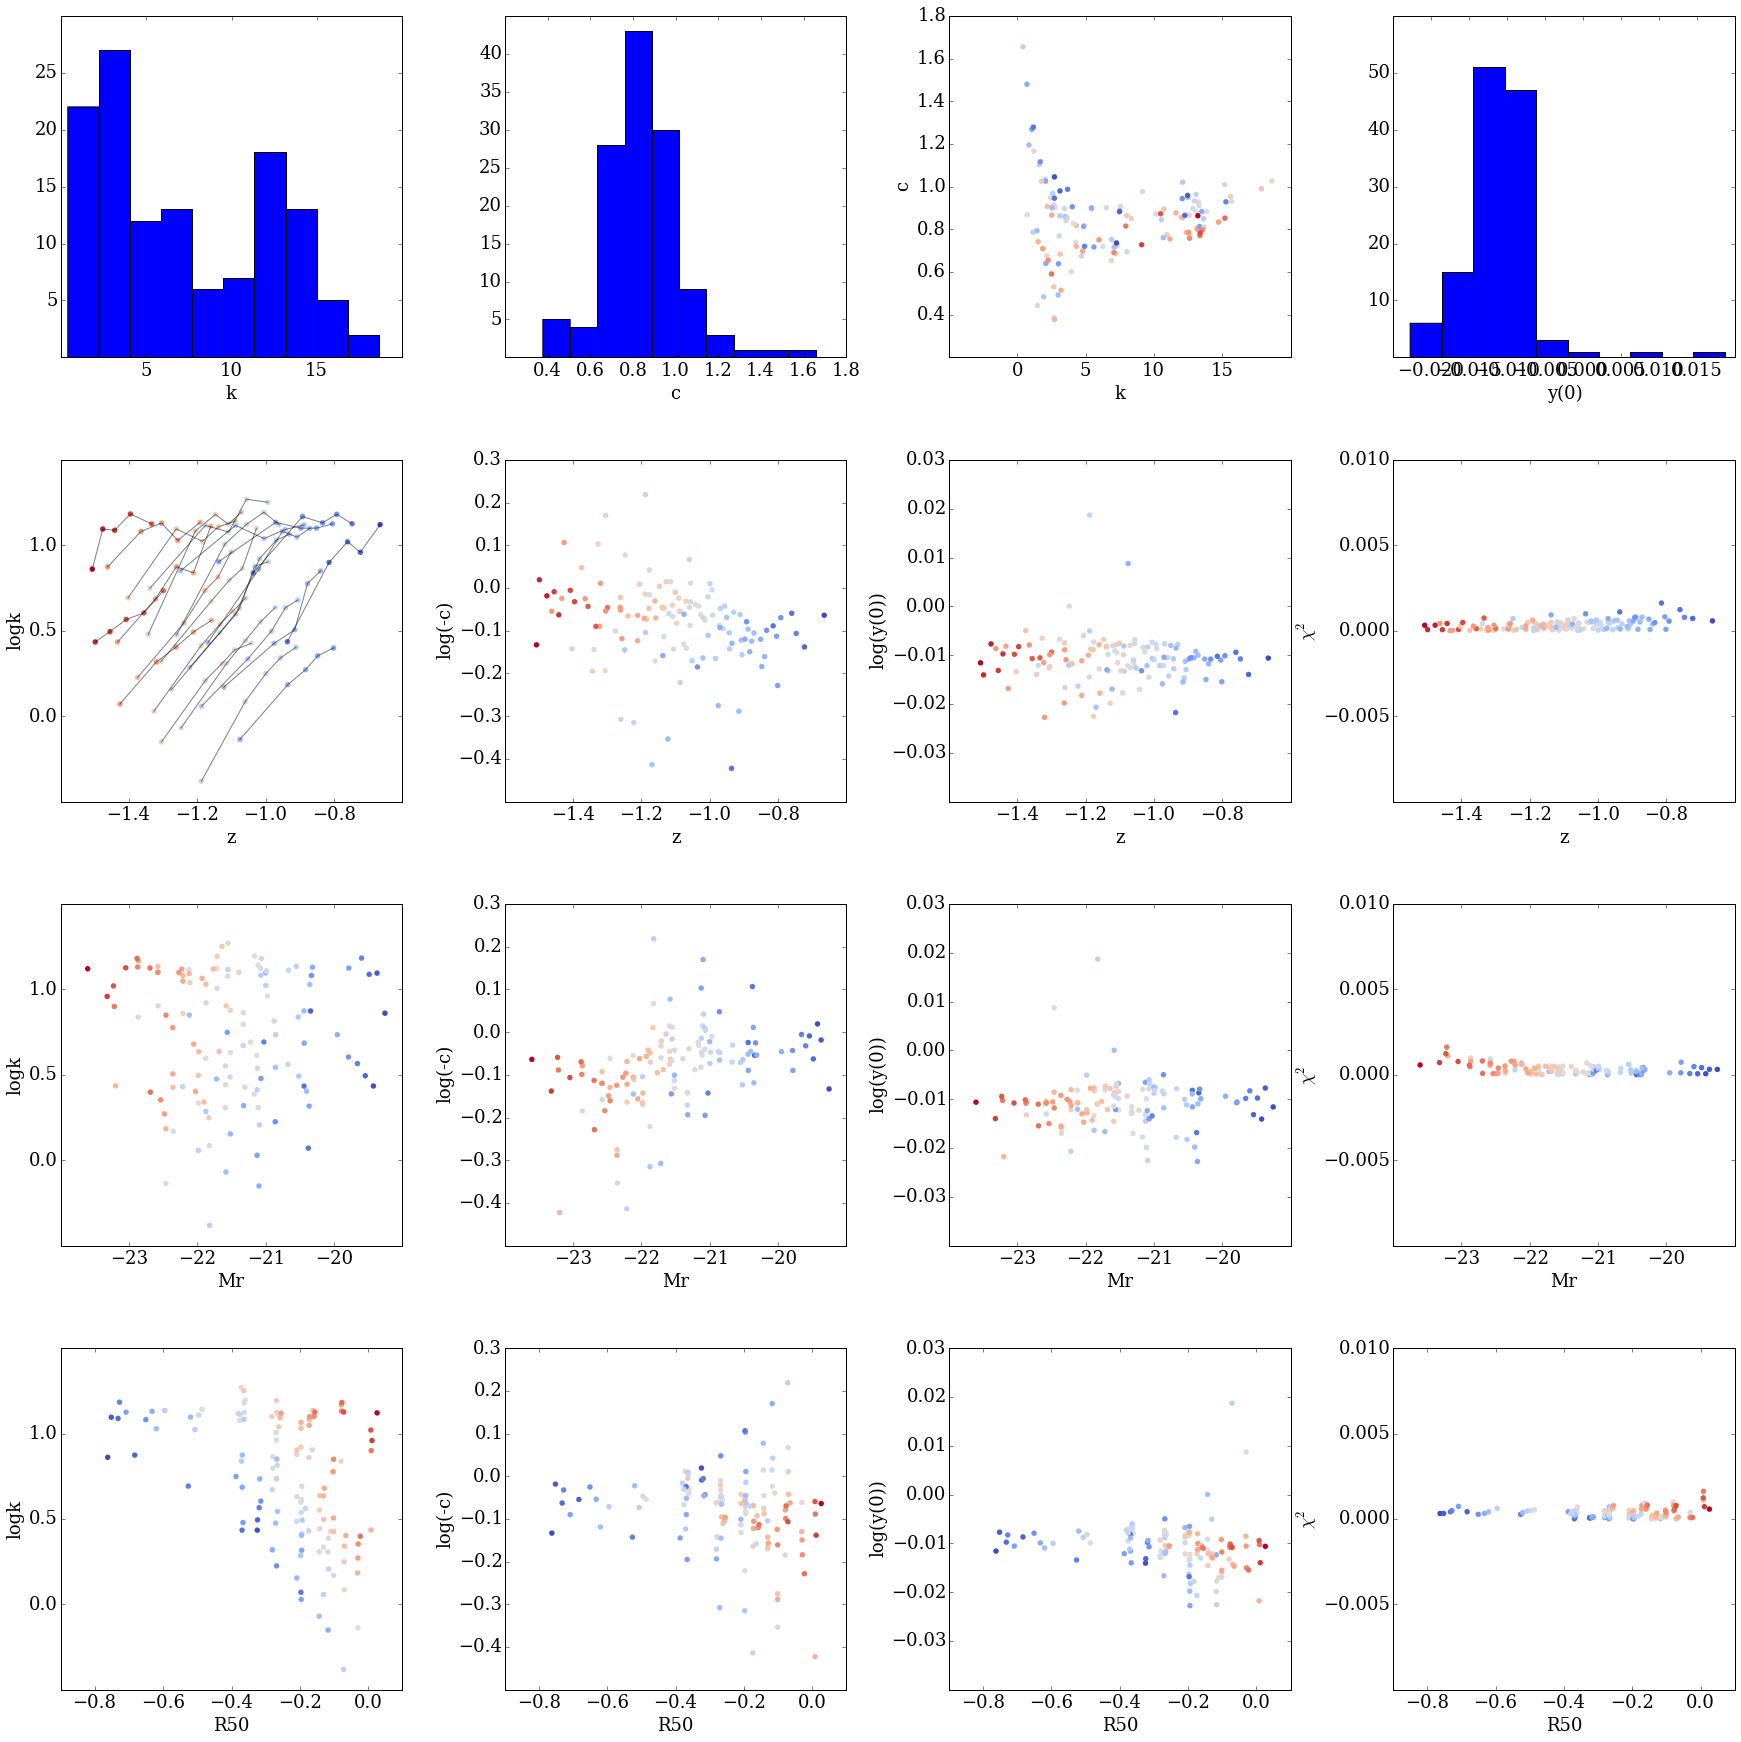

In [223]:
fig,axes = plt.subplots(4,4,figsize=(30,30))
plt.subplots_adjust(hspace=0.3,wspace=0.3)

chisq = fit_vbin_results['chi2nu']
k = fit_vbin_results['k']
c = fit_vbin_results['c']
l = fit_vbin_results['l']
z = np.log10(fit_vbin_results['redshift'])
y0 = f_logistic(0,k,c,l)
Mr = fit_vbin_results['Mr']
R50 = np.log10(fit_vbin_results['R50'])
vb = fit_vbin_results['vbin']

axrow = 0
axes[axrow,0].hist(k)
axes[axrow,0].set_xlabel('k')
axes[axrow,1].hist(c)
axes[axrow,1].set_xlabel('c')
axes[axrow,2].scatter(k,c,c=z,cmap=plt.cm.coolwarm,marker='o',lw=0,s=30)
axes[axrow,2].set_xlabel('k')
axes[axrow,2].set_ylabel('c')
axes[axrow,3].hist(y0)
axes[axrow,3].set_xlabel('y(0)')

plot_row(axes,1,z,Mr,'z')
plot_row(axes,2,Mr,z,'Mr',vbins=None)
plot_row(axes,3,R50,z,'R50',vbins=None)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in power


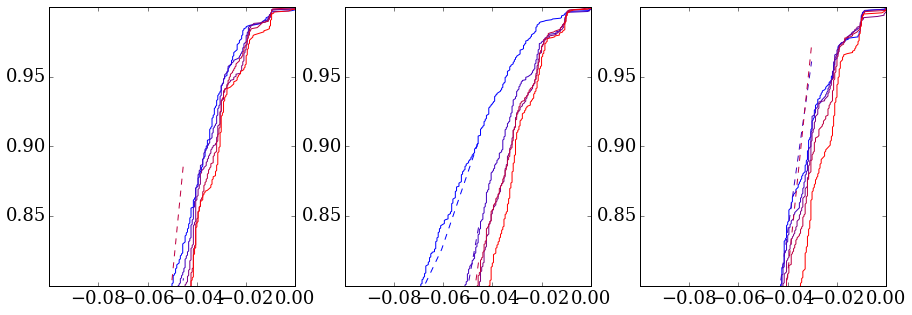

In [221]:
# Plot some of the chisq best fits, to see what happened?

bright_bin = 18
faint_bin = 24
middle_bin = 0
# Got by eye from the voronoi plot.

data_column = question + '_' + answer + '_weighted_fraction'
fv = data[data_column]

fig,axes = plt.subplots(1,3,figsize=(15,5))

for n,v in enumerate([faint_bin,middle_bin,bright_bin]):
    
    colors = np.linspace(0,1,5)
    
    v_select = fit_vbin_results['vbin'] == v
    k_fits = fit_vbin_results['k'][v_select]
    c_fits = fit_vbin_results['c'][v_select]
    l_fits = fit_vbin_results['l'][v_select]
    
    xg = np.linspace(-1.5,0,100)
    
    for r,k in enumerate(k_fits):
        
        fv_vz = fv[(vbins == v) & (zbins == r+1)]
        fv_vz = np.sort(fv_vz)
        fv_nonzero = fv_vz != 0
        cf = np.linspace(0,1,len(fv_vz))
        
        fv_plot = np.log10(fv_vz[fv_nonzero])
        cf_plot = cf[fv_nonzero]
        
        clr = colors[r]
        color=[clr,0,1-clr]
        
        k = k_fits[r]
        c = c_fits[r]
        l = l_fits[r]
        axes[n].plot(fv_plot,cf_plot,color=color,linestyle='solid')
        axes[n].plot(xg,f_exp_pow(xg,k,c,l),color=color,linestyle='dashed')
        
    axes[n].set_xlim(-0.1,0)
    axes[n].set_ylim(0.8,1)

In [ ]:
def make_axes(n_morph,xlabel='$\log(f_v)$',ylabel='cumulative fraction'):

    x_dimension = math.ceil(math.sqrt(n_morph))
    y_dimension = math.ceil(n_morph/x_dimension)
    n_plots = x_dimension*y_dimension
    n_spare = n_plots-n_morph
    remove_axes = np.arange(-n_spare,0)
    fig,axes = plt.subplots(y_dimension,x_dimension,sharex=True,sharey=True,figsize=(5*x_dimension,5*y_dimension))
    if n_morph >= 3:
        for ax in axes[-1,:]:
            ax.set_xlabel(xlabel)
        for ax in axes[:,0]:
            ax.set_ylabel(ylabel) 
    else:
        axes[0].set_xlabel(xlabel)
        axes[0].set_ylabel(ylabel)
        axes[1].set_xlabel(xlabel)
    plt.subplots_adjust(hspace=0,wspace=0)
    axes=axes.ravel()
    for m in remove_axes:
        fig.delaxes(axes[m])
    return fig,axes

In [ ]:
fit_setup = make_setup_dictionary(data,question,questions,function_dictionary,
                                   vbin=None)

fit_vbin_results = fit_vbin_function(data,vbins,zbins,fit_setup,question,questions)

In [ ]:
def plot_fit_vbin(question,questions,parameter='k', predictor=None):
    
    answerlabels = questions[question]['answerlabels']
    
    n_morph = 1
    fig, axarr = plt.subplots(n_morph, 3, sharey='row', sharex='col', figsize=(15,3*n_morph))
    def plot(ax, x, answer, colourby):
        r = fit_vbin_results[fit_vbin_results['answer'] == answer]
        if predictor is None:
            param = r[parameter]
        else:
            f, p = predictor
            var = np.array([r[c] for c in ['Mr', 'R50', 'redshift']], np.float64)
            if p is not None:
                param = f(var, *p[answer])
            else:
                param = f(var)
        ax.scatter(r[x], param, c=r[colourby], marker='.', edgecolor='')
        y, bin_edges, binnumber = binned_statistic(r[x], r[parameter], statistic='median')
        xc = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.plot(xc, y, 'k-')
        if predictor is not None:
            y, bin_edges, binnumber = binned_statistic(r[x], param, statistic='median')
            xc = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            ax.plot(xc, y, 'k--')
        low, high = plot_limits(r[parameter])
        ax.axis(ymin=low, ymax=high)
    for a, axrow in enumerate(axarr):
        plot(axrow[0], 'redshift', a, 'vbin')
        plot(axrow[1], 'R50', a, 'redshift')
        plot(axrow[2], 'Mr', a, 'redshift')
        axrow[0].set_ylabel("${}$ ({})".format(parameter,answerlabels[a]))
        if a == len(axarr) - 1:
            axrow[0].set_xlabel('$z$')
            axrow[1].set_xlabel('$\log_{10}{R_{50}}$')
            axrow[2].set_xlabel('$M_r$')
    fig.subplots_adjust(hspace=0, wspace=0)

In [ ]:
from scipy.optimize import curve_fit


def kcfunc(x, A0, AM, AR, Az):#,nz):
    # linear combination of (magnitude, size, redshift) + an offset
    #logr = A0 + AM*(10**(x[0])) + AR*(x[1]) + Az*(x[2])
    
    logr = A0 + AM*(10**(x[0])) + AR*(x[1]) + Az*(x[2])
    
    return logr


def fit_mrz(d, f=kcfunc,clip=None):
    # Fit a linear function of M, R and z to k and c
    
    dout = d.copy()
    dout['kf'] = np.zeros(len(d))
    dout['cf'] = np.zeros(len(d))
    dout['lf'] = np.zeros(len(d))
    
    kparams = []
    cparams = []
    lparams = []
    # Set limits of the functions here.
    kmin = d['k'].min() 
    kmax = d['k'].max() 
    cmin = d['c'].min()
    cmax = d['c'].max()
    lmin = d['l'].min()
    lmax = d['l'].max()

    # Loop over GZ morphologies
    x = np.array([d[c] for c in ['Mr', 'R50', 'redshift']], np.float64)
    k = d['k'].astype(np.float64)
    c = d['c'].astype(np.float64)
    l = d['l'].astype(np.float64)

    kp, kc = curve_fit(f, x, k, maxfev=100000)
    cp, cc = curve_fit(f, x, c, maxfev=100000)
    lp, lc = curve_fit(f, x, l, maxfev=100000)
        
    kres = f(x, *kp) - k
    knormres = normalise(kres)

    cres = f(x, *cp) - c
    cnormres = normalise(cres)
        
    lres = f(x, *cp) - l
    lnormres = normalise(lres)
    
    bins = np.linspace(-3,3,15)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.hist(knormres,color='r',alpha=0.5,bins=bins)
    plt.subplot(1,3,2)
    plt.hist(cnormres,color='b',alpha=0.5,bins=bins)
    plt.subplot(1,3,3)
    plt.hist(lnormres,color='g',alpha=0.5,bins=bins)
    plt.xlabel('residual')
    plt.ylabel('N')
        
    if clip != None:
        
        clipped = (np.absolute(knormres) < clip) & (np.absolute(cnormres) < clip) # 'clip' sigma clipping
        kp, kc = curve_fit(f, ((x.T)[clipped]).T, k[clipped], maxfev=100000)
        cp, cc = curve_fit(f, ((x.T)[clipped]).T, c[clipped], maxfev=100000)
        lp, lc = curve_fit(f, ((x.T)[clipped]).T, c[clipped], maxfev=100000)

        dout['kf'] = f(x, *kp)
        dout['cf'] = f(x, *cp)
        dout['lf'] = f(x, *lp)

        kparams.append(kp)
        cparams.append(cp)
        lparams.append(lp)
        
        plt.subplot(1,3,1)
        plt.hist(knormres[clipped],color='r',bins=bins)
        plt.subplot(1,3,2)
        plt.hist(cnormres[clipped],color='b',bins=bins)
        plt.subplot(1,3,3)
        plt.hist(lnormres[clipped],color='g',bins=bins)
        plt.xlabel('residual')
        plt.ylabel('N')

    return kparams, cparams, lparams, dout, kmin, kmax, cmin, cmax,lmin,lmax


def normalise(x):
    return (x - x.mean())/x.std()

In [ ]:
fit_vbin_results['Mr_norm'] = normalise(fit_vbin_results['Mr'])
fit_vbin_results['R50_norm'] = normalise(fit_vbin_results['R50'])
fit_vbin_results['redshift_norm'] = normalise(fit_vbin_results['redshift'])

kparams, cparams,lparams,dout, kmin, kmax, cmin, cmax,lmin,lmax = fit_mrz(fit_vbin_results, kcfunc,clip=1)

In [ ]:
colours = 'rbgmc'
colours = 'r'

#answer1 (smooth) = red
#answer2 (features) = blue
#answer3 (artifact) = green

plt.subplot(2,2,1)

plt.scatter(dout['kf'], dout['k'], c=colours,
            marker='.', edgecolor='', alpha=1)

plt.plot([0, 6], [0, 6], 'k-')
plt.xlabel('$k$ fit')
plt.ylabel('$k$')

plt.subplot(2,2,2)

plt.scatter(dout['redshift'], dout['kf']-dout['k'], c=colours,
            marker='.', edgecolor='', alpha=1)

plt.xlabel('$z$')
plt.ylabel('$k$ fit - $k$')

plt.subplot(2,2,3)

plt.scatter(dout['Mr'], dout['kf']-dout['k'], c=colours,
            marker='.', edgecolor='', alpha=1)
plt.xlabel('$M_r$')
plt.ylabel('$k$ fit - $k$')

plt.subplot(2,2,4)

plt.scatter(dout['R50'], dout['kf']-dout['k'], c=colours,
            marker='.', edgecolor='', alpha=1)
plt.xlabel('$R_{50}$')
plt.ylabel('$k$ fit - $k$')


In [ ]:
colours = 'rbgmc'
colours = 'b'

#answer1 (smooth) = red
#answer2 (features) = blue
#answer3 (artifact) = green

plt.subplot(2,2,1)

plt.scatter(dout['cf'], dout['c'], c=colours,
            marker='.', edgecolor='', alpha=1)

plt.plot([0, 6], [0, 6], 'k-')
plt.xlabel('$c$ fit')
plt.ylabel('$c$')
_ = plt.axis((0, 2, 0, 2))

plt.subplot(2,2,2)

plt.scatter(dout['redshift'], dout['cf']-dout['c'], c=colours,
            marker='.', edgecolor='', alpha=1)
plt.xlabel('$z$')
plt.ylabel('$c$ fit - $c$')

plt.subplot(2,2,3)

plt.scatter(dout['Mr'], dout['cf']-dout['c'], c=colours,
            marker='.', edgecolor='', alpha=1)
plt.xlabel('$M_r$')
plt.ylabel('$c$ fit - $c$')

plt.subplot(2,2,4)

plt.scatter(dout['R50'], dout['cf']-dout['c'], c=colours,
            marker='.', edgecolor='', alpha=1)
plt.xlabel('$R_{50}$')
plt.ylabel('$c$ fit - $c$')

In [ ]:
colours = 'rbgmc'
colours = 'g'

#answer1 (smooth) = red
#answer2 (features) = blue
#answer3 (artifact) = green

plt.subplot(2,2,1)

plt.scatter(dout['lf'], dout['l'], c=colours,
            marker='.', edgecolor='', alpha=1)

plt.plot([0, 6], [0, 6], 'k-')
plt.xlabel('$l$ fit')
plt.ylabel('$l$')
_ = plt.axis((0, 2, 0, 2))

plt.subplot(2,2,2)

plt.scatter(dout['redshift'], (dout['lf']-dout['l'])/dout['l'], c=colours,
            marker='.', edgecolor='', alpha=1)

plt.xlabel('$z$')
plt.ylabel('$l$ fit - $l$')
_ = plt.axis((0, 0.3, -1, 1))

plt.subplot(2,2,3)

plt.scatter(dout['Mr'], (dout['lf']-dout['l'])/dout['l'], c=colours,
            marker='.', edgecolor='', alpha=1)
plt.xlabel('$M_r$')
plt.ylabel('$l$ fit - $l$')

plt.subplot(2,2,4)

plt.scatter(dout['R50'], (dout['lf']-dout['l'])/dout['l'], c=colours,
            marker='.', edgecolor='', alpha=1)
plt.xlabel('$R_{50}$')
plt.ylabel('$l$ fit - $l$')

In [ ]:
def function_inversion(value,func,k,kb,c,cb):
    # for use when function has no mathematical inverse
    xg = np.log10(np.linspace(0.01,1,100))
    low_z_values = func(xg,kb,cb)
    high_z_value = func(value,k,c)
    i = (np.abs(low_z_values-high_z_value)).argmin()
    x = xg[i]
    return x

In [ ]:
def debias(data, z_base, kcfunc, kparams, cparams,lparams,
           question,questions,kmin,kmax,cmin,cmax,lmin,lmax):
    # Debias the dataset
    
    fv_col = question + '_' + answer + '_weighted_fraction'
    # Each galaxy gets a function fit to its M,R and z parameters, which are scaled
    # to the equivalent M and r functions at low z.
    
    fv = data[fv_col]
    debiased = np.zeros(len(fv))
    fv_nonzero = fv > 0
    log10fv = np.log10(np.asarray(fv[fv_nonzero]))
    func, _, _ = get_fit_setup(fit_setup)
    i_func = fit_setup['inverse']
    bounds = fit_setup['bounds']
    #------
    d  = data[fv_nonzero]
        
    x = np.array([d['PETROMAG_MR'],
                 np.log10(d['PETROR50_R_KPC']),
                 d['REDSHIFT_1']], np.float64)
    xb  = x.copy()
    xb[-1] = z_base
        
    k = kcfunc(x, *kparams[0])
    c = kcfunc(x, *cparams[0])
    l = kcfunc(x, *lparams[0])
    
    k[k < kmin] = kmin
    k[k > kmax] = kmax
    c[c < cmin] = cmin
    c[c > cmax] = cmax
    l[l < lmin] = lmin
    l[l > lmax] = lmax

    #create version of x with all redshifts at z_base
    kb = kcfunc(xb, *kparams[0])
    cb = kcfunc(xb, *cparams[0])
    lb = kcfunc(xb, *lparams[0])
        
    kb[kb < kmin] = kmin
    kb[kb > kmax] = kmax
    cb[cb < cmin] = cmin
    cb[cb > cmax] = cmax
    lb[lb < lmin] = lmin
    lb[lb > lmax] = lmax
        
    # Need to deal with any values outside of the function limits here.
            
    plt.subplot(2,1,1)
    plt.hist(kb,color='b',alpha=0.5,histtype='stepfilled')
    plt.hist(k,color='b',histtype='step',linewidth=2)
    plt.vlines(bounds[0][0],0,10**5,color='b')
    plt.vlines(bounds[0][1],0,10**5,color='b')
            
    plt.subplot(2,1,2)
    plt.hist(cb,color='r',histtype='stepfilled',alpha=0.5)
    plt.hist(c,color='r',histtype='step',linewidth=2)
    plt.vlines(bounds[1][0],0,10**5,color='r')
    plt.vlines(bounds[1][1],0,10**5,color='r')

        #possibly deal with any functions outside the k and c limits here
    if i_func == None:
        log10fv_debiased = np.array([function_inversion(log10fv[v],func,k[v],kb[v],c[v],cb[v]) 
                                     for v in range(len(log10fv))])
        
    else:
        cumfrac = func(log10fv, k, c,l)
        log10fv_debiased = i_func(cumfrac, kb, cb,lb)
        
    fv_debiased = 10**(log10fv_debiased)
    debiased[fv_nonzero] = fv_debiased

    return debiased
    #return bounds

In [ ]:
debiased = debias(data,0.03, kcfunc, kparams, cparams,lparams,
                  question,questions,kmin,kmax,cmin,cmax,lmin,lmax)

In [ ]:
# Now need to plot a z-trend...
answers = questions[question]['answers']

norm = False

bins = np.linspace(0.03,0.085,11)
bin_centres = [bins[n]+(bins[n+1]-bins[n])/2 for n in range(len(bins)-1)]
bin_vals = np.digitize(vl_data['REDSHIFT_1'],bins=bins)

sum_deb = np.zeros(len(debiased))
for c in debiased.colnames:
    sum_deb = sum_deb + debiased[c]

n_morph = debiased.colnames
labels = ['smooth','features','artifact']

th = 0.5

clr = ['red','blue','green']

for m, morph in enumerate(n_morph):
    
    deb = debiased.copy()
    
    if norm == True:
        for c in debiased.colnames:
            deb[c] = debiased[c]/sum_deb # Normalise.
    
    fracs_deb = [np.sum(deb[bin_vals == b][morph] > th)/len(deb[bin_vals == b])
                 for b in np.unique(bin_vals)]
    
    w13 = Table([vl_data[question + '_' + a + '_debiased'] for a in answers])
    
    morph2 = w13.colnames
    
    fracs_w13 = [np.sum(w13[bin_vals == b][morph2[m]] > th)/len(w13[bin_vals == b])
                 for b in np.unique(bin_vals)]
    
    plt.plot(bin_centres,fracs_deb,label=labels[m],linewidth=2,color=clr[m])
    plt.plot(bin_centres,fracs_w13,label=labels[m],linewidth=2,linestyle='dashed',color=clr[m])
    plt.legend(loc=3)

In [ ]:
volume_select = (data['REDSHIFT_1'] < 0.085) & (data['PETROMAG_MR'] < -21)

high_z = (data['REDSHIFT_1'] >= 0.07) & (data['REDSHIFT_1'] < 0.08)
low_z = (data['REDSHIFT_1'] >= 0.03) & (data['REDSHIFT_1'] < 0.04)

In [ ]:
fv = data[question + '_' + answer + '_weighted_fraction']
fv_deb = debiased

plt.hist(fv[(volume_select) & (low_z)],histtype='step',color='k',linewidth=2,normed=True)
#plt.hist(fv_deb[(volume_select) & (high_z)],histtype='step',color='r',linewidth=2,normed=True)

In [ ]:
plt.scatter(data[question + '_' + answer + '_weighted_fraction'][volume_select],
            debiased[volume_select],alpha=0.5,
            c=np.log10(data['REDSHIFT_1'][volume_select]),cmap='coolwarm',marker='.')

plt.axis([0,1,0,1])